# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Logística

### Import required libraries and dataset

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime
from os.path import exists
tf.config.set_visible_devices([], 'GPU')

2023-05-21 23:21:34.597854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 23:21:34.732441: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-21 23:21:35.309237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tdrather/anaconda3/envs/nn-tp1/lib
2023-05-21 23:21:35.309302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp

/home/tdrather/anaconda3/envs/nn-tp1/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Download and load Fashion MNIST dataset

In [5]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

### Normalize the dataset

In [6]:
data_max = np.max(train_X)
train_X = train_X.astype('float32') / data_max
test_X = test_X.astype('float32') / data_max
np.max(train_X)

1.0

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

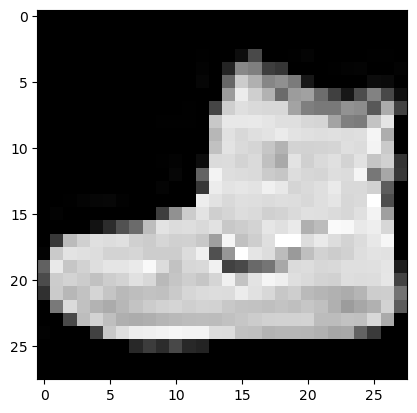

In [7]:
plt.imshow(train_X[0,...], cmap="gray")

#### Show a few instances of each class

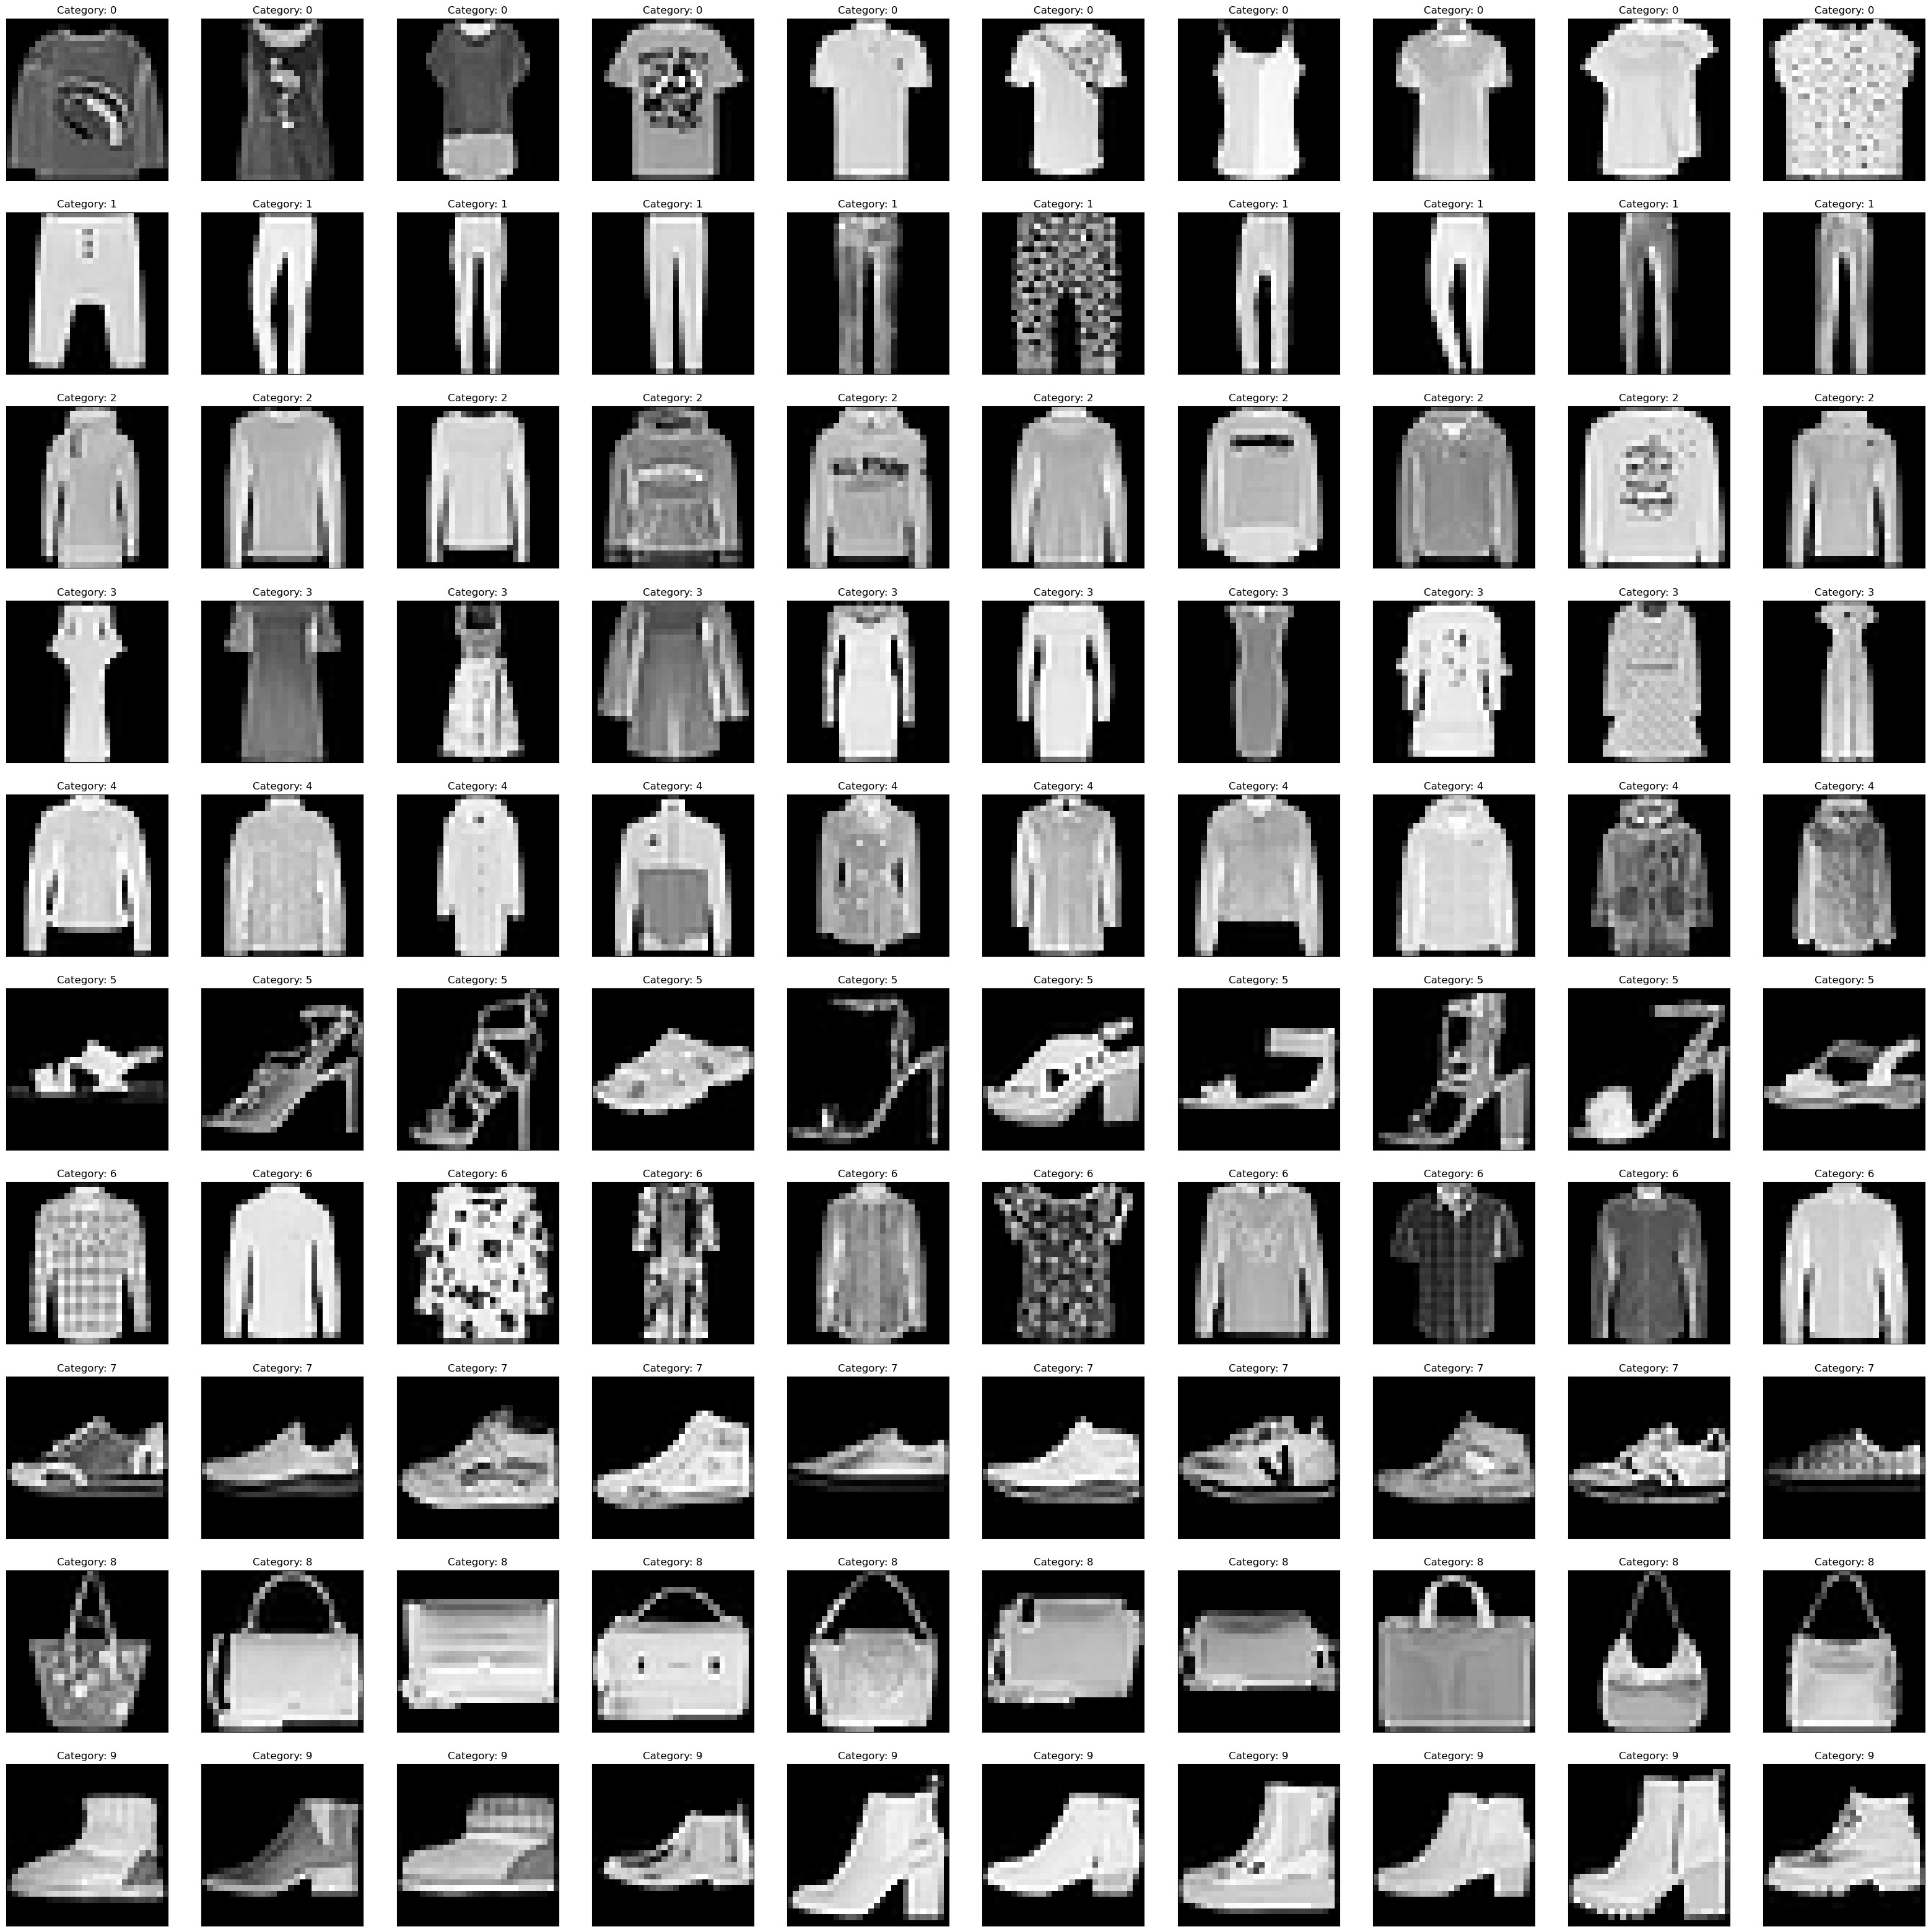

In [8]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(train_y)

train_X_sorted = np.array(train_X)[idx]
train_y_sorted = np.array(train_y)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[i + count * 6000,:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(train_y_sorted[i + count * 6000]))

#### Look at the data distribution

##### Training data

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


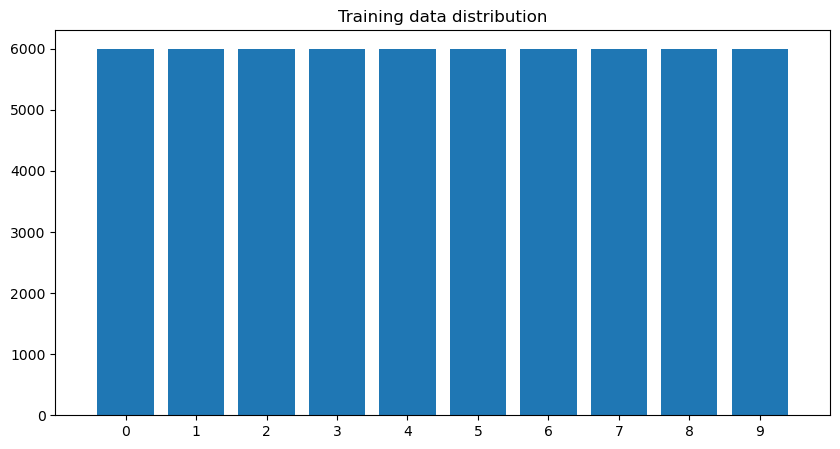

In [9]:
unique, counts = np.unique(train_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(train_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


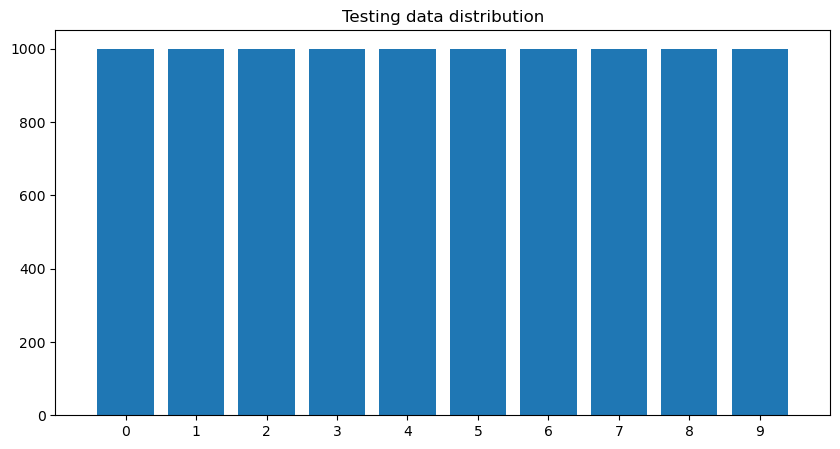

In [10]:
unique, counts = np.unique(test_y, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(test_y)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [6]:
num_classes = np.max(train_y) + 1
train_y_cat = utils.to_categorical(train_y, num_classes)
test_y_cat = utils.to_categorical(test_y, num_classes)

### Softmax

#### Config the model to be trained

##### Preeliminary Optimizer Analysis

In [29]:
METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="Accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="Loss (val.)",
    ),
    hp.Metric(
        "epoch_f1_score",
        group="validation",
        display_name="F1 Score Macro (val.)",
    ),
    hp.Metric(
        "epoch_f1_score_micro",
        group="validation",
        display_name="F1 Score Micro (val.)",
    ),
    hp.Metric(
        "epoch_recall",
        group="validation",
        display_name="Recall (val.)",
    ),
    hp.Metric(
        "epoch_precision",
        group="validation",
        display_name="Precision (val.)",
    ),
]

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop', 'adamw', 'nadam', 'adagrad', 'adadelta', 'ftrl', 'adamax', 'adafactor']))
HP_LEARN_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001, 0.01, 0.1]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([ 0.9, 0.95, 0.99]))
HP_NESTEROV = hp.HParam('nesterov', hp.Discrete([True, False]))
HP_RHO = hp.HParam('rho', hp.Discrete([0.92, 0.95, 0.97]))
HP_BETA_1 = hp.HParam('beta_1', hp.Discrete([0.86, 0.9, 0.94]))
HP_BETA_2 = hp.HParam('beta_2', hp.Discrete([0.97, 0.99, 0.999]))
HP_BETA_2_DECAY = hp.HParam('beta_2_decay', hp.Discrete([-0.9, -0.8, -0.7]))
HP_WEIGHT_DECAY = hp.HParam('weight_decay', hp.Discrete([0.0001, 0.001, 0.004, 0.01]))
HP_LEARN_RATE_POWER = hp.HParam('learning_rate_power', hp.Discrete([-0.8, -0.5, -0.0]))

HPARAMS = [HP_OPTIMIZER, HP_LEARN_RATE, HP_MOMENTUM, HP_NESTEROV, HP_RHO, HP_BETA_1, HP_BETA_2, HP_BETA_2_DECAY, HP_WEIGHT_DECAY, HP_LEARN_RATE_POWER]

In [1]:
# Callback to stop training if, after 5 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

NameError: name 'tf' is not defined

In [31]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/softmax'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [32]:
# Logs and metrics from TensorBoard
log_dir = "logs/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [33]:
def train_test_model(hparams, run_dir):
  softmax_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax),
  ])

  if(hparams[HP_OPTIMIZER] == 'sgd'):
    optimizer = optimizers.SGD(learning_rate=hparams[HP_LEARN_RATE], momentum=hparams[HP_MOMENTUM], nesterov=hparams[HP_NESTEROV])
  elif(hparams[HP_OPTIMIZER] == 'adam'):
    optimizer = optimizers.Adam(learning_rate=hparams[HP_LEARN_RATE])
  elif(hparams[HP_OPTIMIZER] == 'rmsprop'):
    optimizer = optimizers.RMSprop(learning_rate=hparams[HP_LEARN_RATE], rho=hparams[HP_RHO], momentum=hparams[HP_MOMENTUM])
  elif(hparams[HP_OPTIMIZER] == 'adadelta'):
    optimizer = optimizers.Adadelta(learning_rate=hparams[HP_LEARN_RATE], rho=hparams[HP_RHO])
  elif(hparams[HP_OPTIMIZER] == 'adagrad'):
    optimizer = optimizers.Adagrad(learning_rate=hparams[HP_LEARN_RATE])
  elif(hparams[HP_OPTIMIZER] == 'adamax'):
    optimizer = optimizers.Adamax(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'nadam'):
    optimizer = optimizers.Nadam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'ftrl'):
    optimizer = optimizers.Ftrl(learning_rate=hparams[HP_LEARN_RATE], learning_rate_power=hparams[HP_LEARN_RATE_POWER])

  softmax_model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
  )

  callbacks = [
      early_stop_callback,
      tf.keras.callbacks.TensorBoard(run_dir),# log metrics
      hp.KerasCallback(run_dir, hparams),  # log hparams
    ]

  softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs = 5, callbacks=callbacks)

In [34]:
with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=HPARAMS,
    metrics=METRICS,
  )

In [35]:
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
  for learning_rate in HP_LEARN_RATE.domain.values:
    if(optimizer == 'adagrad'):
      hparams = {
        HP_OPTIMIZER: optimizer,
        HP_LEARN_RATE: learning_rate,
      }
      run_name = "/run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      train_test_model(hparams, log_dir + run_name)
      session_num += 1
    elif(optimizer == 'adadelta'):
      for rho in HP_RHO.domain.values:
        hparams = {
          HP_OPTIMIZER: optimizer,
          HP_LEARN_RATE: learning_rate,
          HP_RHO: rho,
        }
        run_name = "/run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        train_test_model(hparams, log_dir + run_name)
        session_num += 1
    elif(optimizer == 'ftrl'):
      for learning_rate_power in HP_LEARN_RATE_POWER.domain.values:
        hparams = {
          HP_OPTIMIZER: optimizer,
          HP_LEARN_RATE: learning_rate,
          HP_LEARN_RATE_POWER: learning_rate_power,
        }
        run_name = "/run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        train_test_model(hparams, log_dir + run_name)
        session_num += 1
    elif(optimizer == 'sgd' or optimizer == 'rmsprop'):
      for momentum in HP_MOMENTUM.domain.values:
        if(optimizer == 'sgd'):
          for nesterov in HP_NESTEROV.domain.values:
            hparams = {
              HP_OPTIMIZER: optimizer,
              HP_LEARN_RATE: learning_rate,
              HP_MOMENTUM: momentum,
              HP_NESTEROV: nesterov,
            }
            run_name = "/run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            train_test_model(hparams, log_dir + run_name)
            session_num += 1
        else:
          for rho in HP_RHO.domain.values:
            hparams = {
              HP_OPTIMIZER: optimizer,
              HP_LEARN_RATE: learning_rate,
              HP_MOMENTUM: momentum,
              HP_RHO: rho,
            }
            run_name = "/run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            train_test_model(hparams, log_dir + run_name)
            session_num += 1
    elif(optimizer == 'adam' or optimizer == 'adamax' or optimizer == 'nadam'):
      for beta_1 in HP_BETA_1.domain.values:
        for beta_2 in HP_BETA_2.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_BETA_1: beta_1,
            HP_BETA_2: beta_2,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1

--- Starting trial: /run-0
{'optimizer': 'adadelta', 'learning_rate': 0.0001, 'rho': 0.92}
Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 179.9036 - accuracy: 0.1432 - f1_score: 0.0982 - f1_score_micro: 0.1432 - precision: 0.1432 - recall: 0.1432 - val_loss: 175.4375 - val_accuracy: 0.1410 - val_f1_score: 0.1011 - val_f1_score_micro: 0.1410 - val_precision: 0.1410 - val_recall: 0.1410
Epoch 2/5
938/938 [==============================] - 1s 2ms/step - loss: 173.0348 - accuracy: 0.1446 - f1_score: 0.1056 - f1_score_micro: 0.1446 - precision: 0.1446 - recall: 0.1446 - val_loss: 168.9558 - val_accuracy: 0.1414 - val_f1_score: 0.1069 - val_f1_score_micro: 0.1414 - val_precision: 0.1414 - val_recall: 0.1413
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 166.9953 - accuracy: 0.1468 - f1_score: 0.1130 - f1_score_micro: 0.1468 - precision: 0.1468 - recall: 0.1468 - val_loss: 163.3462 - val_accuracy: 0.1438 - val_f1_score: 0.1133 - val_f1_score

In [37]:
%tensorboard --logdir $log_dir

Tenemos entonces un análisis preeliminar de los distintos optimizadores disponibles, y observamos que los que mejor se comportan en terminos de maximizar la accuracy son SGD, Adam y Nadam.
Estos resultados son claramente imperfectos ya que:
- Fueron realizados a solo 5 epochs (lo que le da una ventaja a learning rates altos, y no todos los optimizadores se comportan bien con los mismos).
- No se analizaron otras cuestiones como agregar capas de dropout, batch normalization o cambiar la función de costo, que podrían mejorar la performance de algunos optimizadores en específico.
Sin embargo, sirve como análisis preeliminar para observar cuales optimizadores se comportan bien en general para este problema y realizar un análisis más en profundidad de los mismos, para no requerir tanto tiempo de entrenamiento.

##### First Hyperparameter Tuning with Best Optimizers

Buscamos obtener los mejores hiperparámetros para los optimizadores que mejor se comportaron en el análisis preeliminar, para luego realizar un análisis más en profundidad de los mismos.

In [ ]:
# HP_BATCH_RATE = hp.HParam('batch_size', hp.Discrete([32, 64, 128, 256]))
HP_LOSSES = hp.HParam('loss', hp.Discrete(['categorical_crossentropy', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'log_cosh']))
# HP_ACTIVATIONS = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']))
# HP_DENSE_LAYERS = hp.HParam('dense_layers', hp.Discrete([1, 2, 3, 4]))
# HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([32, 64, 128, 256, 512]))
# HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))
# HP_BATCH_NORMALIZATION = hp.HParam('batch_normalization', hp.Discrete([True, False]))
# HP_WEIGHT_INITIAL = hp.HParam('weight_initialization', hp.Discrete(['glorot_uniform', 'glorot_normal', 'random_normal_std_1', 'random_normal_std_1e-3']))

HP_LEARN_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([ 0.9, 0.95, 0.99]))
HP_NESTEROV = hp.HParam('nesterov', hp.Discrete([True, False]))
HP_BETA_1 = hp.HParam('beta_1', hp.Discrete([0.86, 0.9, 0.94]))
HP_BETA_2 = hp.HParam('beta_2', hp.Discrete([0.97, 0.99, 0.999]))

HPARAMS = [HP_LOSSES, HP_LEARN_RATE, HP_MOMENTUM, HP_NESTEROV, HP_BETA_1, HP_BETA_2]

In [ ]:
# Logs and metrics from TensorBoard
log_dir = "logs/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
def train_test_model(hparams, run_dir):
  softmax_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax),
  ])
  

  if(hparams[HP_OPTIMIZER] == 'sgd'):
    optimizer = optimizers.SGD(learning_rate=hparams[HP_LEARN_RATE], momentum=hparams[HP_MOMENTUM], nesterov=hparams[HP_NESTEROV])
  elif(hparams[HP_OPTIMIZER] == 'adam'):
    optimizer = optimizers.Adam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  elif(hparams[HP_OPTIMIZER] == 'nadam'):
    optimizer = optimizers.Nadam(learning_rate=hparams[HP_LEARN_RATE], beta_1=hparams[HP_BETA_1], beta_2=hparams[HP_BETA_2])
  
  softmax_model.compile(
      optimizer=optimizer,
      loss=hparams[HP_LOSSES],
      metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
  )

  callbacks = [
      early_stop_callback,
      tf.keras.callbacks.TensorBoard(run_dir),# log metrics
      hp.KerasCallback(run_dir, hparams),  # log hparams
    ]

  softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs = 100, callbacks=callbacks)

In [ ]:
with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=HPARAMS,
    metrics=METRICS,
  )

In [20]:
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
  for learning_rate in HP_LEARN_RATE.domain.values:
    if(optimizer == 'sgd'):
      for momentum in HP_MOMENTUM.domain.values:
        for nesterov in HP_NESTEROV.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_MOMENTUM: momentum,
            HP_NESTEROV: nesterov,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1
    elif(optimizer == 'adam' or optimizer == 'nadam'):
      for beta_1 in HP_BETA_1.domain.values:
        for beta_2 in HP_BETA_2.domain.values:
          hparams = {
            HP_OPTIMIZER: optimizer,
            HP_LEARN_RATE: learning_rate,
            HP_BETA_1: beta_1,
            HP_BETA_2: beta_2,
          }
          run_name = "/run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          train_test_model(hparams, log_dir + run_name)
          session_num += 1

##### Final testing with best hyperparameters

In [22]:
softmax_model =  Sequential()
#model.add(preprocessing.RandomFlip("horizontal", input_shape=(28,28,1)))
# model.add(layers.Dropout(0.1, input_shape=(28,28)))
softmax_model.add(layers.Flatten(input_shape=(28,28)))
softmax_model.add(layers.Dense(num_classes, activation="softmax"))
softmax_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [ ]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [ ]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/softmax'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Logs and metrics from TensorBoard
log_dir_fit = "logs/fit/softmax/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_fit, histogram_freq=1)

In [ ]:
optimizer = SGD(learning_rate=0.0002, momentum=0.95)
softmax_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

#### Fit the model to the train data and validate it with the test data

In [ ]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # softmax_model.load_weights(checkpoint_filepath)

In [ ]:
softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

#### Plot important metrics

##### TensorBoard session

In [ ]:
%tensorboard --logdir logs/fit

##### Loss

In [ ]:
plt.plot(softmax_history.history["loss"], label="Train")
plt.plot(softmax_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - Softmax')
plt.show()

##### Accuracy

In [ ]:
plt.plot(softmax_history.history["accuracy"], label="Train")
plt.plot(softmax_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - Softmax')
plt.show()

##### Precision

In [ ]:
plt.plot(softmax_history.history["precision"], label="Train")
plt.plot(softmax_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - Softmax')
plt.show()

##### Recall

In [ ]:
plt.plot(softmax_history.history["recall"], label="Train")
plt.plot(softmax_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - Softmax')
plt.show()

##### F1-Score

###### Macro

In [ ]:
plt.plot(softmax_history.history["f1_score"], label="Train")
plt.plot(softmax_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - Softmax')
plt.show()

###### Micro

In [ ]:
plt.plot(softmax_history.history["f1_score_micro"], label="Train")
plt.plot(softmax_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - Softmax')
plt.show()

##### ROC and AUC

In [ ]:
# Plot linewidth.
lw = 2

# Get score
y_score = softmax_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - Softmax')
plt.legend(loc="lower right")
plt.show()

### MLP

In [ ]:
mlp_model = Sequential()
mlp_model.add(layers.Flatten(input_shape=(28,28)))
mlp_model.add(layers.Dense(256, activation='relu'))
mlp_model.add(layers.Dense(64, activation='relu'))
mlp_model.add(layers.Dense(num_classes, activation="softmax"))
mlp_model.summary()

#### Compile the model

In [ ]:
mlp_model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0002, momentum=0.95),metrics=["accuracy", tfa.metrics.F1Score(average='macro',num_classes=num_classes),tfa.metrics.F1Score(average='micro',num_classes=num_classes, name="f1_score_micro"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [ ]:
# Callback to stop training if, after 2 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [ ]:
# Callback to save the weights of the best model
checkpoint_filepath = '/tmp/checkpoint/mlp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Logs and metrics from TensorBoard
log_dir_fit = "logs/fit/mlp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_fit, histogram_freq=1)

#### Fit the model to the train data and validate it with the test data

In [ ]:
# We load the previously best weights to save time on training
# if (exists(checkpoint_filepath)):
    # mlp_model.load_weights(checkpoint_filepath)

In [ ]:
mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[tensorboard_callback, early_stop_callback])
# softmax_history = softmax_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])
# mlp_history = mlp_model.fit(train_X, train_y_cat, validation_data=(test_X, test_y_cat), batch_size = 64, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback, early_stop_callback])

#### Plot important metrics

##### TensorBoard session

In [ ]:
%tensorboard --logdir logs/fit

##### Loss

In [ ]:
plt.plot(mlp_history.history["loss"], label="Train")
plt.plot(mlp_history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution through epochs - MLP')
plt.show()

##### Accuracy

In [ ]:
plt.plot(mlp_history.history["accuracy"], label="Train")
plt.plot(mlp_history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution through epochs - MLP')
plt.show()

##### Precision

In [ ]:
plt.plot(mlp_history.history["precision"], label="Train")
plt.plot(mlp_history.history["val_precision"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision evolution through epochs - MLP')
plt.show()

##### Recall

In [ ]:
plt.plot(mlp_history.history["recall"], label="Train")
plt.plot(mlp_history.history["val_recall"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall evolution through epochs - MLP')
plt.show()

##### F1 Score

###### Macro

In [ ]:
plt.plot(mlp_history.history["f1_score"], label="Train")
plt.plot(mlp_history.history["val_f1_score"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) evolution through epochs - MLP')
plt.show()

###### Micro

In [ ]:
plt.plot(mlp_history.history["f1_score_micro"], label="Train")
plt.plot(mlp_history.history["val_f1_score_micro"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) evolution through epochs - MLP')
plt.show()

##### ROC and AUC

In [ ]:
# Plot linewidth.
lw = 2

# Get score
y_score = mlp_model.predict(test_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(20,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))
    
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed - Extension of Receiver Operating Characteristic to multi-class - MLP')
plt.legend(loc="lower right")
plt.show()